<a href="https://colab.research.google.com/github/mmt-1234/rne/blob/main/rne_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self,lr,input_dims,fc1_dims,fc2_dims,n_actions):
        super(DeepQNetwork,self).__init__()
        self.input_dims=input_dims
        self.fc1_dims=fc1_dims
        self.fc2_dims=fc2_dims
        self.n_actions=n_actions
        self.fc1=nn.Linear(*self.input_dims,self.fc1_dims)
        self.fc2=nn.Linear(self.fc1_dims,self.fc2_dims)
        self.fc3=nn.Linear(self.fc2_dims,self.n_actions)
        self.optimizer=optim.Adam(self.parameters(),lr=lr)
        self.loss=nn.MSELoss()
        self.loss.requires_grad_(True)
        self.device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self,state):
        x=F.relu(self.fc1(state))
        x=F.relu(self.fc2(x))
        actions=self.fc3(x)
        return actions

class Agent():
    def __init__(self,gamma,epsilon,lr,input_dims,batch_size,n_actions,max_mem_size=100000,eps_end=0.01,eps_dec=5e-5):
        self.gamma=gamma
        self.epsilon=epsilon
        self.eps_min=eps_end
        self.eps_dec=eps_dec
        self.lr=lr
        self.action_space=[i for i in range(n_actions)]
        self.mem_size=max_mem_size
        self.batch_size=batch_size
        self.mem_cntr=0

        #self.Q_eval=DeepQNetwork(self.lr,n_actions=n_actions,input_dims=input_dims,fc1_dims=256,fc2_dims=256)
        try:
            self.PATH='/content/drive/MyDrive/test/'
            self.Q_eval=DeepQNetwork(self.lr,n_actions=n_actions,input_dims=input_dims,fc1_dims=256,fc2_dims=256)
            model = torch.load(self.PATH + 'RLmodel.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
            self.Q_eval.load_state_dict(torch.load(self.PATH + 'RLmodel_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

            checkpoint = torch.load(self.PATH + 'RLall.tar')   # dict 불러오기
            self.Q_eval.load_state_dict(checkpoint['model'])
            self.Q_eval.optimizer=optim.Adam(self.Q_eval.parameters(),lr=self.lr)
            self.Q_eval.optimizer.load_state_dict(checkpoint['optimizer'])
            self.Q_eval.train()
            print('model Before')
        except Exception as e:
            print(e)
            print('new Model')
            self.Q_eval=DeepQNetwork(self.lr,n_actions=n_actions,input_dims=input_dims,fc1_dims=256,fc2_dims=256)

        self.state_memory=np.zeros((self.mem_size,*input_dims),dtype=np.float32)
        self.new_state_memory=np.zeros((self.mem_size,*input_dims),dtype=np.float32)

        self.action_memory=np.zeros(self.mem_size,dtype=np.int32)
        self.reward_memory=np.zeros(self.mem_size,dtype=np.float32)
        self.terminal_memory=np.zeros(self.mem_size,dtype=np.bool_)

    def load_model(self,PATH):

        net = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
        net.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

        checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
        net.load_state_dict(checkpoint['model'])
        optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
        optimizer.load_state_dict(checkpoint['optimizer'])

    def store_transition(self,state,action,reward,state_,done):
        index=self.mem_cntr%self.mem_size
        self.state_memory[index]=state
        self.new_state_memory[index]=state_
        self.reward_memory[index]=reward
        self.action_memory[index]=action
        self.terminal_memory[index]=done

        self.mem_cntr+=1

    def choose_action(self,observation):
        if np.random.random() > self.epsilon:
            state=torch.tensor(np.array([observation])).to(self.Q_eval.device)
            actions=self.Q_eval.forward(state.to(torch.float32))
            action=torch.argmax(actions).item()
        else:
            action=np.random.choice(self.action_space)

        return action

    def learn(self):
        if self.mem_cntr<self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()

        max_mem=min(self.mem_cntr,self.mem_size)
        batch=np.random.choice(max_mem,self.batch_size,replace=False)

        batch_index=np.arange(self.batch_size,dtype=np.int32)
        state_batch=torch.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch=torch.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch=torch.tensor(self.reward_memory[batch],requires_grad=True).to(self.Q_eval.device)
        terminal_batch=torch.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]

        q_eval=self.Q_eval.forward(state_batch)[batch_index,action_batch]
        q_next=self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch]=0.0

        q_target=reward_batch + self.gamma * torch.max(q_next,dim=1)[0]

        loss=self.Q_eval.loss(q_target,q_eval).to(self.Q_eval.device)
        loss.requires_grad_(True)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon=self.epsilon-self.eps_dec if self.epsilon > self.eps_min else self.eps_min

    def save_model(self):
        PATH='/content/drive/MyDrive/test/'
        torch.save(self.Q_eval, PATH + 'RLmodel.pt')  # 전체 모델 저장
        torch.save(self.Q_eval.state_dict(), PATH + 'RLmodel_state_dict.pt')  # 모델 객체의 state_dict 저장
        torch.save({
            'model': self.Q_eval.state_dict(),
            'optimizer': self.Q_eval.optimizer.state_dict()
        }, PATH + 'RLall.tar')
        print('Model is saved!')


In [ ]:
!pip install gymnasium

In [ ]:
import gymnasium
from gymnasium.spaces import Discrete,Box,Dict
from google.colab.patches import cv2_imshow
import numpy as np
import random
import pygame
import cv2
import time
import colorsys
class Risk(gym.Env):
    def __init__(self,field,width,height,start_x,start_y,end_x,end_y):
        super(Risk,self).__init__()
        self.field=np.array(field)
        self.start=[start_x,start_y]
        self.end=[end_x,end_y]
        self.grid=np.zeros((width,height))
        self.current=[0,0]
        self.width=width
        self.height=height
        self.action_space=Discrete(4)
        self.observation_space=Dict({
            "state":Box(0,max(self.width,self.height),self)
        })
        self.risk=0
        self.first=True
        pygame.init()
        self.cell_width=20
        self.cell_height=20
        self.screen=pygame.display.set_mode((self.height*self.cell_height,self.width*self.cell_width))
        self.position=[[],[]]
        self.myFont = pygame.font.SysFont( "arial", 10, True, False)

        fourcc = cv2.VideoWriter_fourcc(*'MP4V')

        # 웹캠으로 찰영한 영상을 저장하기
        # cv2.VideoWriter 객체 생성, 기존에 받아온 속성값 입력
        filename=str(time.time())[-3::]
        print(filename)
        self.out = cv2.VideoWriter('output'+filename+'.mp4', fourcc, 120, (self.height*self.cell_height, self.width*self.cell_width))
    def reset(self,seed=None,options=None):
        self.seed_num=seed
        self.current=self.start
        self.risk=0
        self.grid=np.zeros((self.width,self.height))
        self.position=[[],[]]
        self.first=True
        return self.current

    def step(self,action):
        new=np.array(self.current)
        if action==0:
            new[0]-=1
        elif action==1:
            new[0]+=1
        elif action==2:
            new[1]-=1
        elif action==3:
            new[1]+=1
        # self.risk+=self.field[new[0]-1][new[1]-1]
        if new[0]==self.end[0] and new[1]==self.end[1]:
            done=True
        else:
            done=False

            if self._is_valid_position(new):
                self.current=new
                self.position[0].append(new[0])
                self.position[1].append(new[1])
                self.risk+=self.field[self.current[0]][self.current[1]]
                self.render()
        # 보상 함수 정의
        if done:
            reward = 200  # 목표 지점 도달 시 큰 보상
        elif self.current[0]==2 and self.current[1]==4 and self.first:
            reward = 1
            self.first=False
            print('first gone')
        else:
            reward = -1-self.field[self.current[0]][self.current[1]]*20  # 일반 이동 시 작은 페널티
        if self.risk >= 1:
            done = True
            reward = -self.risk*200


        # 상태, 보상, 종료 여부, 추가 정보 반환
        return np.array(self.current, dtype=np.int32), reward, done, {"risk": self.risk}

    def _is_valid_position(self, pos):
        row, col = pos

        if row < 0 or col < 0 or row >= self.width or col >= self.height:
            return False
        elif self.field[row][col]==-1 :
            return False
        return True

    def get_color(self,value):
        color=colorsys.hsv_to_rgb(0,0.3+value*7/5,1)
        return (int(color[0]*255),int(color[1]*255),int(color[2]*255))

    def render(self):
        # Clear the screen
        self.screen.fill((255, 255, 255))

        #draw risk
        for i in range(self.width):
            for j in range(self.height):
                if self.field[i][j] > 10**-5:
                    #colour=(int(120*self.field[i][j]/0.5)+75,50,int(120*(self.field[i][j])/0.5)+75)
                    colour=self.get_color(self.field[i][j])
                    pygame.draw.rect(self.screen,colour,pygame.Rect(j*self.cell_height,i*self.cell_width,self.cell_height,self.cell_width))

                if self.field[i][j]==-1:
                    col=(0,0,0)
                    pygame.draw.rect(self.screen,col,pygame.Rect(j*self.cell_height,i*self.cell_width,self.cell_height,self.cell_width))

        #the way move
        for i in range(1,len(self.position[0])):
            pygame.draw.line(self.screen,'RED',(self.position[1][i-1]*self.cell_height,self.position[0][i-1]*self.cell_width),(self.position[1][i]*self.cell_height,self.position[0][i]*self.cell_width))

        #mark start and goal
        pygame.draw.circle(self.screen,'BLUE',(self.start[1]*self.cell_height+self.cell_height,self.start[0]*self.cell_width-self.cell_width//2),self.cell_width//3,2)
        pygame.draw.circle(self.screen,'BLUE',(self.cell_height*self.end[1]+self.cell_height,self.cell_width*self.end[0]-self.cell_width//2),self.cell_width//3,2)
        text_goal = self.myFont.render("Goal", True, [0,0,0])
        text_start = self.myFont.render("Start", True, [0,0,0])
        self.screen.blit(text_goal, (self.cell_height*self.end[1]+self.cell_height,(self.end[0]+1)*self.cell_width))
        self.screen.blit(text_start, (self.start[1]*self.cell_height-self.cell_height//2,self.cell_width*self.start[0]))

        #draw title and episode
        text_Title= self.myFont.render("Episode :"+str(episode), True, [0,0,0])
        self.screen.blit(text_Title, [self.cell_height*self.height-self.cell_height*7,self.cell_width])
        image_string = pygame.image.tostring(self.screen, 'RGB')

    # 문자열을 numpy 배열로 변환
        image_np = np.frombuffer(image_string, dtype=np.uint8)
        image_np = image_np.reshape((self.width*self.cell_width,self.height*self.cell_height, 3))
        # RGB 채널을 BGR 채널로 변환 (OpenCV는 BGR을 사용)
        image_np = image_np[:, :, ::-1]
        # 프레임을 비디오 라이터에 기록
        self.out.write(image_np)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pygame
from google.colab.patches import cv2_imshow
import cv2


In [ ]:
class PF:
    def __init__(self,width,height,rep):
        self.width=width
        self.height=height
        self.X=np.arange(0,width,1)
        self.Y=np.arange(0,height,1)
        self.X,self.Y=np.meshgrid(self.X,self.Y)
        self.rep=rep
        self.V=[[0]*self.height for _ in range(self.width)]

        self.circles=[]
    def setCircle(self,x,y,r=7.5):
        self.circles.append((x,y))
        #ax.add_patch(plt.Circle((x,y),r,fc='green',ec='white',alpha=0.5))

    def setPF(self,d):
        a = []
        self.DIST = d

        for i in range(self.width):
            for j in range(self.height):
                self.V[i][j] +=  self.rep * np.exp(-(self.getDist(i,j,False)**2)) if self.rep * np.exp(-(self.getDist(i,j,False)**2))>10**-5 else 0

    def reload(self,t):
        for i in range(self.width):
            for j in range(self.height):
                self.V[i][j] += self.rep*(1+t/100) * np.exp(-(self.getDist(i,j,False)**2)/t) if self.rep*(1+t/100)* np.exp(-(self.getDist(i,j,False)**2)/t)>10**-5 else 0

    def setObstacle(self,x1,x2,y1,y2):
        for i in range(x1,x2):
            for j in range(y1,y2):
                self.V[i][j]=-1

    def forceA(self,x,y):
        return [-self.att*(x-100),-self.att*(y-100)]
    def getDist(self,x,y,t):
        M=10**10
        cx,cy=0,0
        for nx,ny in self.circles:
            M=min(M,((nx-x)**2+(ny-y)**2)**0.5)
            if abs(M-((nx-x)**2+(ny-y)**2)**0.5)<10**-6:
                cx,cy=nx,ny
        if t:
            return M,cx,cy
        else:
            return M

    def forceB(self,x,y):
        D,cx,cy=self.getDist(x,y,True)
        if 0<D<=self.DIST and (cx!=0 and cy!=0):
            return [self.rep * (1 / D - 1 / self.DIST) * (1 / D/ D) * (x - cx) / D, self.rep * (1 / D - 1 / self.DIST) * (1 / D / D) * (y - cy) / D]
        else:
            return 0,0
    def setDoor(self,x,y):
        self.V[x][y]=0

In [ ]:
PATH='/content/drive/MyDrive/test/'

net = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수
net.load_state_dict(torch.load(PATH + 'model_state_dict.pt'))  # state_dict를 불러 온 후, 모델에 저장

checkpoint = torch.load(PATH + 'all.tar')   # dict 불러오기
net.load_state_dict(checkpoint['model'])
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer'])

<ipython-input-8-e13c1faf3aae>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(PATH + 'model.pt')  # 전체 모델을 통째로 불러옴, 클래스 선언 필수


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/test/model.pt'

In [ ]:
size=20
pf=PF(18,43,0.5)
pf.setCircle(6,21)
pf.setCircle(1,6)
pf.setCircle(14,15)
pf.setCircle(1,20)
pf.setCircle(1,1)
pf.setCircle(16,6)
pf.setCircle(5,28)
pf.setCircle(10,35)
pf.setPF(10)

pf.setObstacle(7,8,0,18)
pf.setObstacle(8,18,17,18)
pf.setObstacle(8,18,3,4)
pf.setObstacle(8,18,10,11)
pf.setObstacle(7,8,24,43)
pf.setObstacle(8,18,24,25)
pf.setObstacle(8,18,39,40)
pf.setObstacle(8,18,31,32)
pf.setObstacle(3,4,0,18)
pf.setObstacle(0,4,17,18)
pf.setObstacle(0,4,3,4)
pf.setObstacle(0,4,10,11)
pf.setObstacle(3,4,24,43)
pf.setObstacle(0,4,24,25)
pf.setObstacle(0,4,39,40)
pf.setObstacle(0,4,31,32)
pf.setDoor(3,2)
pf.setDoor(7,2)
pf.setDoor(3,8)
pf.setDoor(7,8)
pf.setDoor(3,15)
pf.setDoor(7,15)
pf.setDoor(3,26)
pf.setDoor(7,26)
pf.setDoor(3,33)
pf.setDoor(7,33)
pf.setDoor(3,40)
pf.setDoor(7,40)
for i in range(0,43):
    print("{0: >3}".format(i),end='')
print()
print()
for i in pf.V:
    for j in i:
        print("{0: >3}".format(round(j*10)),end='')
    print()

  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42

  1  2  1-10  0  1  2  1  0  0-10  0  0  0  0  0  0-10  0  1  2  1  0  0-10  0  0  0  0  0  0-10  0  0  0  0  0  0  0-10  0  0  0
  2  5  2-10  0  2  5  2  0  0-10  0  0  0  0  0  0-10  0  2  5  2  0  0-10  0  0  0  0  0  0-10  0  0  0  0  0  0  0-10  0  0  0
  1  2  1-10  0  1  2  1  0  0-10  0  0  0  0  0  0-10  0  1  2  1  0  0-10  0  0  0  0  0  0-10  0  0  0  0  0  0  0-10  0  0  0
-10-10  0-10-10-10-10-10  0-10-10-10-10-10-10  0-10-10  0  0  0  0  0  0-10-10  0-10-10-10-10-10-10  0-10-10-10-10-10-10  0-10-10
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  1  0  0  0  0  2  5  2  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  5  2  0  0  0  0  1  2  

In [ ]:
import gymnasium as gym
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import cv2,sys
import pickle

gym.envs.register(
    id='Risk',
    entry_point='__main__:Risk',
)

agent=Agent(gamma=0.99,epsilon=1,lr=0.001,input_dims=[2],batch_size=64,n_actions=4,max_mem_size=10000)

# with open('/content/drive/MyDrive/test/agent2.pkl', 'rb') as f:
#     agent=pickle.load(f)

In [ ]:

episode=1

if __name__=='__main__':
    scores,eps_history, avg_scores= [],[],[]
    n_games=150
    env=gym.make('Risk',field = pf.V,width= 18,height=43,start_x=12,start_y=6,end_x=4,end_y=18)
    for i in range(n_games):
        score=0
        done=False
        episode=i
        observation=env.reset()
        t=1
        while not done:
            action=agent.choose_action(observation)
            observation_,reward,done,info=env.step(action)
            score+=reward
            agent.store_transition(observation,action,reward,observation_,done)

            agent.learn()
            observation=observation_
            if t>200 or score<=-200:
                break
            # pf.reload(t)
            t+=1

        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score=np.mean(scores[-100:])
        avg_scores.append(avg_score)

        print(f"episode :{i}, score : {score:.3f}, average score {avg_score:.3f}, epsilon {agent.epsilon:.3f}, Total Risk: {info['risk']:.2f})")
    x=[i+1 for i in range(n_games)]
    plt.title('Real World')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.plot(x, scores,label='Score')
    plt.plot(x,avg_scores,label='Average Score')
    plt.legend()
    plt.show()
    env.out.release()


705
[12  5]
[11  5]
[11  6]
[11  5]
[12  5]
[11  5]
[12  5]
[12  6]
[12  5]
[12  6]
[12  7]
[12  8]
[12  7]
[13  7]
[13  8]
[13  9]
[12  9]
[13  9]
[13  9]
[12  9]
[13  9]
[12  9]
[12  9]
[13  9]
[13  9]


/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'list'>`
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:212: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


[12  9]
[12  8]
[12  7]
[11  7]
[12  7]
[12  8]
[12  7]
[11  7]
[10  7]
[11  7]
[10  7]
[10  6]
[10  5]
[9 5]
[9 4]
[10  4]
[10  5]
[10  6]
[9 6]
[9 5]
[10  5]
[10  4]
[9 4]
[9 4]
[9 5]
[8 5]
[9 5]
[10  5]
[10  4]
[10  5]
[10  4]
[10  4]
[10  5]
[10  4]
[10  4]
[10  5]
[10  6]
[10  7]
[11  7]
[10  7]
[10  8]
[11  8]
[11  9]
[10  9]
[10  9]
[10  8]
[10  9]
[11  9]
[11  9]
[11  8]
[10  8]
[10  9]
[10  9]
[9 9]
[8 9]
[8 9]
[9 9]
[9 8]
[9 7]
[9 8]
[8 8]
[9 8]
[9 9]
[9 8]
[9 7]
[9 8]
[9 9]
[8 9]
[9 9]
[10  9]
[10  8]
[10  9]
[10  9]
[10  8]
[11  8]
[10  8]
[10  7]
[9 7]
[10  7]
[11  7]
[12  7]
[12  8]
[12  7]
[12  8]
[13  8]
[12  8]
[12  7]
[12  6]
[12  5]
[12  4]
[13  4]
[14  4]
[15  4]
[14  4]
[14  4]
[14  5]
[15  5]
[15  6]
[14  6]
[14  7]
[15  7]
[15  6]
[14  6]
[15  6]
[15  5]
[16  5]
[15  5]
episode :0, score : -357.396, average score -357.396, epsilon 0.997, Total Risk: 1.04)
[12  5]
[11  5]
[10  5]
[10  6]
[10  5]
[9 5]
[8 5]
[8 6]
[9 6]
[9 5]
[8 5]
[8 4]
[8 5]
[9 5]
[8 5]
[9 5]
[9 

KeyboardInterrupt: 

In [ ]:
PATH='/content/drive/MyDrive/test/'
torch.save(net, PATH + 'model.pt')  # 전체 모델 저장
torch.save(net.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': net.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')

NameError: name 'net' is not defined

In [ ]:
import pickle
with open('/content/drive/MyDrive/test/agent2.pkl', 'wb') as f:
    pickle.dump(agent, f)

In [ ]:
print(agent.Q_eval.input_dims)

[2]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


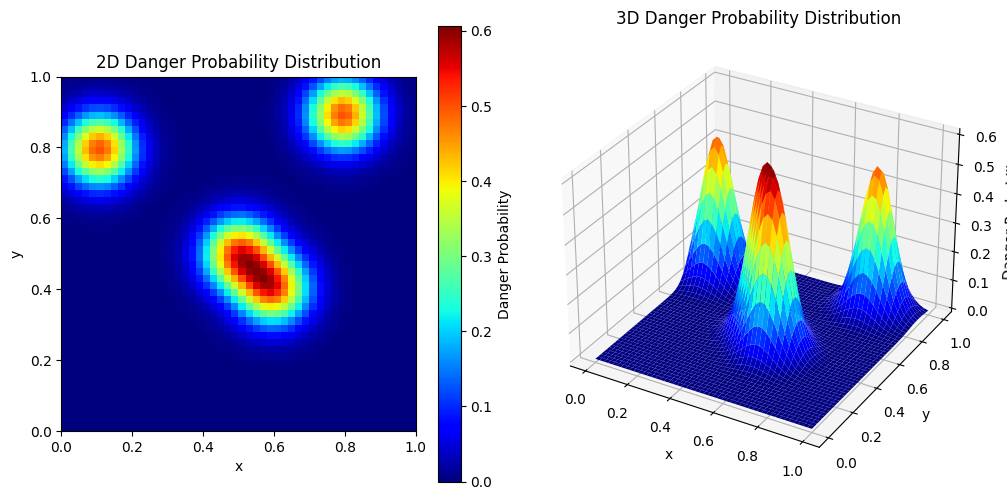

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. 데이터 생성 (임의의 위험 확률 데이터)
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)
X, Y = np.meshgrid(x, y)

# 임의의 함수로 위험 확률 생성 (화재 발생 확률 분포 가정)
Z = 0.5*(np.exp(-((X - 0.5)**2 + (Y - 0.5)**2) / 0.01) + np.exp(-((X - 0.1)**2 + (Y - 0.8)**2) / 0.01) + np.exp(-((X - 0.6)**2 + (Y - 0.4)**2) / 0.01)+np.exp(-((X - 0.8)**2 + (Y - 0.9)**2) / 0.01))

# 2. 2D 그래프 그리기
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='jet')
plt.colorbar(label='Danger Probability')
plt.xlabel('x')
plt.ylabel('y')
plt.title('2D Danger Probability Distribution')

# 3. 3D 그래프 그리기
ax = plt.subplot(1, 2, 2, projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('Danger Probability')
ax.set_title('3D Danger Probability Distribution')

# 4. 그래프 표시
plt.tight_layout()
plt.show()
